In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd

from shapely.wkt import loads
from shapely.geometry import Polygon
from shapely.geometry import Point

import rasterio
import rasterio.sample

from scipy.spatial import KDTree

In [2]:
parquet_files = {'marine_protected_areas': ('../data/PR100/Habitat/marine_protected_areas.parquet',
  'EPSG:32161',
  'centroid'),
 'land_nationwide_hapc': ('../data/PR100/Habitat/land_nationwide_hapc.parquet',
  'EPSG:32161',
  'centroid'),
 'artificial_reefs': ('../data/PR100/Habitat/artificial_reefs.parquet',
  'EPSG:32161',
  'irrelevant'),
 'nationwide_hapc': ('../data/PR100/Habitat/nationwide_hapc.parquet',
  'EPSG:32161',
  'irrelevant'),
 'areas_protegidas_agencia': ('../data/PR100/Habitat/areas_protegidas_agencia.parquet',
  'EPSG:32161',
  'centroid'),
 'noaa_charted_submarine_cables_30m_buffer': ('../data/PR100/Infrastructure/noaa_charted_submarine_cables_30m_buffer.parquet',
  'EPSG:32161',
  'irrelevant'),
 'setbacks_xmission': ('../data/PR100/Infrastructure/setbacks_xmission.parquet',
  'EPSG:32161',
  'lines'),
 'submarine_cable_30m_buffer': ('../data/PR100/Infrastructure/submarine_cable_30m_buffer.parquet',
  'EPSG:32161',
  'irrelevant'),
 'pipeline_areas': ('../data/PR100/Infrastructure/pipeline_areas.parquet',
  'EPSG:32161',
  'irrelevant'),
 'setbacks_roads': ('../data/PR100/Infrastructure/setbacks_roads.parquet',
  'EPSG:4326',
  'density'),
 'setbacks_runway': ('../data/PR100/Infrastructure/setbacks_runway.parquet',
  'EPSG:4326',
  'centroid'),
 'setbacks_airport': ('../data/PR100/Infrastructure/setbacks_airport.parquet',
  'EPSG:4326',
  'points'),
 'setbacks_buildings': ('../data/PR100/Infrastructure/setbacks_buildings.parquet',
  'EPSG:4326',
  'density'),
 'federal_and_state_waters': ('../data/PR100/Boundaries/federal_and_state_waters.parquet',
  'EPSG:32161',
  'centroid'),
 'coastal_zone_mgmt_act_boundary': ('../data/PR100/Boundaries/coastal_zone_mgmt_act_boundary.parquet',
  'EPSG:32161',
  'centroid'),
 'land_protected_areas': ('../data/PR100/Boundaries/land_protected_areas.parquet',
  'EPSG:32161',
  'centroid'),
 'water_bodies': ('../data/PR100/Topography/water_bodies.parquet',
  'EPSG:4326',
  'centroid'),
 'wrecks_and_obstructions': ('../data/PR100/Hazards/wrecks_and_obstructions.parquet',
  'EPSG:4326',
  'points'),
 'ocean_disposal_sites': ('../data/PR100/Hazards/ocean_disposal_sites.parquet',
  'EPSG:32161',
  'centroid'),
 'tropical_cyclone_storm_segments': ('../data/PR100/Hazards/tropical_cyclone_storm_segments.parquet',
  'EPSG:32161',
  'lines'),
 'tropical_cyclone_wind_exposure': ('../data/PR100/Hazards/tropical_cyclone_wind_exposure.parquet',
  'EPSG:32161',
  'wind_exposure'),
 'unexploded_ordinance_areas_fuds': ('../data/PR100/Hazards/unexploded_ordinance_areas_fuds.parquet',
  'EPSG:32161',
  'irrelevant'),
 'danger_zones_and_restricted_areas': ('../data/PR100/Hazards/danger_zones_and_restricted_areas.parquet',
  'EPSG:32161',
  'centroid'),
 'unexploded_ordinance_areas': ('../data/PR100/Hazards/unexploded_ordinance_areas.parquet',
  'EPSG:4326',
  'centroid')}

In [3]:
tif_files = ['../data/wind_atlas/PRI_power-density_50m.tif',
 '../data/wind_atlas/PRI_power-density_100m.tif',
 '../data/wind_atlas/PRI_power-density_150m.tif',
 '../data/wind_atlas/PRI_power-density_200m.tif',
 '../data/wind_atlas/PRI_power-density_10m.tif',
 '../data/solar_atlas/Yearly_PVOUT.tif',
 '../data/solar_atlas/Daily_PVOUT.tif',
 '../data/PR100/Topography/slope.tif',
 '../data/PR100/Topography/elevation.tif']

In [4]:
binary_mask_columns = ['marine_protected_areas', 'land_nationwide_hapc',
       'areas_protegidas_agencia', 'setbacks_xmission',
       'setbacks_runway', 'setbacks_airport',
       'federal_and_state_waters', 'coastal_zone_mgmt_act_boundary',
       'land_protected_areas', 'water_bodies', 'wrecks_and_obstructions',
       'ocean_disposal_sites', 'danger_zones_and_restricted_areas',
       'unexploded_ordinance_areas']

In [5]:
def find_parquet_files(directory):
    """
    Find all Parquet files within a directory and its subdirectories.

    :param directory: The base directory to search.
    :return: A list of paths to Parquet files.

    Note: This function isn't used in this notebook, because the file list
    has already been generated and enriched (see 'parquet_files' dict above)
    """
    parquet_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.parquet'):
                parquet_files.append(os.path.join(root, file))
    return parquet_files

In [6]:
def find_tif_files(directory):
    """
    Find all TIF files within a directory and its subdirectories.

    :param directory: The base directory to search.
    :return: A list of paths to TIF files.

    Note: This function isn't used in this notebook, because the file list
    has already been generated (see 'tif_files' dict above)
    """
    tif_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.tif'):
                tif_files.append(os.path.join(root, file))
    return tif_files

In [7]:
def get_gdf(parquet_file, crs, grid):
    df = pd.read_parquet(parquet_file)
    df['geometry'] = df['geometry'].apply(loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.set_crs(crs, inplace=True)
    gdf.to_crs(grid.crs, inplace=True)
    return gdf

In [8]:
def create_grid(x_start, x_end, y_start, y_end, square_size):
    grid = []
    for x in np.arange(x_start, x_end, square_size):
        for y in np.arange(y_start, y_end, square_size):
            # Define the square's coordinates
            square = Polygon([(x, y), (x + square_size, y), (x + square_size, y + square_size), (x, y + square_size)])
            grid.append(square)
    return gpd.GeoDataFrame({'geometry': grid}, crs="EPSG:32161")

In [9]:
# This is a legacy function and is no longer in use

def calculate_cyclone_risk_score(df):
    # Normalize the wind speed occurrences
    max_occurrence = df[['occurrence34kt', 'occurrence50kt', 'occurrence64kt']].max().max()
    df['norm_occurrence34kt'] = df['occurrence34kt'] / max_occurrence
    df['norm_occurrence50kt'] = df['occurrence50kt'] / max_occurrence
    df['norm_occurrence64kt'] = df['occurrence64kt'] / max_occurrence

    # Normalize major hurricanes occurrences
    max_major_hurricanes = df['occurrence64ktMajorHurricanes'].max()
    df['norm_major_hurricanes'] = df['occurrence64ktMajorHurricanes'] / max_major_hurricanes

    # Normalize intersecting storm tracks
    max_intersecting = df['intersectingStormTracks'].max()
    df['norm_intersectingTracks'] = df['intersectingStormTracks'] / max_intersecting

    # Assign weights and calculate risk score
    weights = {
        'norm_occurrence34kt': 0.1,
        'norm_occurrence50kt': 0.2,
        'norm_occurrence64kt': 0.3,
        'norm_major_hurricanes': 0.3,
        'norm_intersectingTracks': 0.1
    }

    df['cyclone_risk_score'] = sum(df[col] * weight for col, weight in weights.items())
    
    return df

In [10]:
def calculate_cyclone_failure_percentage(df):
    probability_of_hurricane_occuring = df['occurrence64ktMajorHurricanes'] / 117
    probability_of_failure_due_to_hurricane = 0.5
    average_life_span = 25
    df['turbine_cyclone_failure_percentage'] = probability_of_hurricane_occuring * probability_of_failure_due_to_hurricane * average_life_span / 2
    return df

In [11]:
def rasterize_cyclone_failure_risk(grid_gdf, cyclone_data_gdf):
    # Ensure both dataframes are in the same CRS
    cyclone_data_gdf = cyclone_data_gdf.to_crs(grid_gdf.crs)

    # Spatial join - to associate cyclone data with each grid cell
    joined_gdf = gpd.sjoin(grid_gdf, cyclone_data_gdf, how='left', predicate='intersects')

    # Apply the failure cost calculation to each row
    joined_gdf = calculate_cyclone_failure_percentage(joined_gdf)

    # Group by grid cell index and average the scores within each cell
    aggregated_scores = joined_gdf.groupby(joined_gdf.index)['turbine_cyclone_failure_percentage'].mean()

    return aggregated_scores.reindex(grid_gdf.index, fill_value=0)

In [12]:
def rasterize(grid, data, type):
    joined_gdf = gpd.sjoin(grid, data[['geometry']], how='right', predicate='intersects')
    count = joined_gdf.groupby('index_left').size().reindex(grid.index, fill_value=0)
    if type == 'density':
        return count
    else:
        return count > 0

In [13]:
def process_parquet_file(file_path, crs, type, handle, grid):
    gdf = get_gdf(file_path, crs, grid)
    if type == 'irrelevant':
        pass
    elif type == 'wind_exposure':
        grid[handle] = rasterize_cyclone_failure_risk(grid, gdf)
    else:
        grid[handle] = rasterize(grid, gdf, type)

In [14]:
def process_parquet_files(files, grid):
    for handle, file_data in files.items():
        file_path = file_data[0]
        crs = file_data[1]
        type = file_data[2]
        print(f'Processing file: {file_path}')
        process_parquet_file(file_path, crs, type, handle, grid)

In [15]:
def process_tif_file(file_path, grid, coords):
    handle = file_path.split('/')[-1].split('.')[0]
    # Open the raster and sample values at each coordinate
    with rasterio.open(file_path) as src:
        if grid.crs != src.crs:
            centroids = grid.geometry.centroid.to_crs(src.crs)
            coords = [(x,y) for x, y in zip(centroids.geometry.x, centroids.geometry.y)]

        # Sample the raster at each centroid location
        values = [x[0] for x in rasterio.sample.sample_gen(src, coords)]
    
    # Assign the values to the grid dataframe
    grid[handle] = values

In [16]:
def process_tif_files(files, grid):
    # Compute centroids
    centroids = grid.geometry.centroid
    # Create an array of coordinates in (x, y) format
    coords = [(x,y) for x, y in zip(centroids.geometry.x, centroids.geometry.y)]

    for file_path in tif_files:
        print(f'Processing file: {file_path}')
        process_tif_file(file_path, grid, coords)

In [17]:
def create_final_binary_mask(grid, binary_mask_columns):
    """
    Create a final binary mask column in the grid dataframe, which is True if any of 
    the specified binary mask columns are True.

    :param grid: DataFrame containing the grid information.
    :param binary_mask_columns: List of columns to be considered for the binary mask.
    :return: Updated DataFrame with an additional 'final_binary_mask' column.
    """

    # Check if any of the specified columns are True for each row
    grid['masked'] = grid[binary_mask_columns].any(axis=1)

In [78]:
def plot_columns(gdf):
    for column in gdf.columns:
        if column in ['geometry', 'centroid']:
            continue
        if not 'wind' in column and not 'PRI' in column:
            continue
        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        environment_gdf.plot(column=column, ax=ax, legend=True)
        plt.title(column)
        plt.show()

In [18]:
environment_gdf = create_grid(100000, 300000, 200000, 300000, 500)

In [19]:
process_parquet_files(parquet_files, environment_gdf)

Processing file: ../data/PR100/Habitat/marine_protected_areas.parquet
Processing file: ../data/PR100/Habitat/land_nationwide_hapc.parquet
Processing file: ../data/PR100/Habitat/artificial_reefs.parquet
Processing file: ../data/PR100/Habitat/nationwide_hapc.parquet
Processing file: ../data/PR100/Habitat/areas_protegidas_agencia.parquet
Processing file: ../data/PR100/Infrastructure/noaa_charted_submarine_cables_30m_buffer.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_xmission.parquet
Processing file: ../data/PR100/Infrastructure/submarine_cable_30m_buffer.parquet
Processing file: ../data/PR100/Infrastructure/pipeline_areas.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_roads.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_runway.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_airport.parquet
Processing file: ../data/PR100/Infrastructure/setbacks_buildings.parquet
Processing file: ../data/PR100/Boundaries/federal_and_state_wat

In [20]:
process_tif_files(tif_files, environment_gdf)

Processing file: ../data/wind_atlas/PRI_power-density_50m.tif
Processing file: ../data/wind_atlas/PRI_power-density_100m.tif
Processing file: ../data/wind_atlas/PRI_power-density_150m.tif
Processing file: ../data/wind_atlas/PRI_power-density_200m.tif
Processing file: ../data/wind_atlas/PRI_power-density_10m.tif
Processing file: ../data/solar_atlas/Yearly_PVOUT.tif
Processing file: ../data/solar_atlas/Daily_PVOUT.tif
Processing file: ../data/PR100/Topography/slope.tif
Processing file: ../data/PR100/Topography/elevation.tif


In [21]:
create_final_binary_mask(environment_gdf, binary_mask_columns)

In [24]:
total_building_density = environment_gdf['setbacks_buildings'].sum()

total_power_density = 100000 # TODO -- Get total power demand for PR

total_power_density_per_building_density = total_power_density / total_building_density

environment_gdf['demand'] = environment_gdf['setbacks_buildings'] * total_power_density_per_building_density

In [25]:
environment_gdf['centroid'] = environment_gdf.centroid

In [26]:
environment_gdf['occupied'] = False

In [31]:
def calculate_transmission_loss_cost(installation, state, type='solar'):
    transmission_loss_percentage = 0.02 # TODO: Change/Support this number
    cost_per_kWh = 100 # TODO: Change/Support this number
    
    if installation['masked']:
        return 0
    for index, cell in state.iterrows():
        cell_demand = cell['demand']
        distance = geodesic(installation.geometry.centroid.coords[0], cell.geometry.centroid.coords[0]).kilometers
        distances.append((cell_demand, distance)) 
            
        sorted_distances = sorted(distances, key = lambda x: x[1])

        # Initialize output_remaining to solar/wind power output
        if type == 'solar':
            output_remaining = installation['solar_power_output']
        elif type == 'wind':
            output_remaining = installation['wind_power_output']
        weighted_distance = 0
        for cell_demand, distance in sorted_distances:
            if output_remaining > 0:
                output_remaining -= cell_demand
                weighted_distance += cell_demand * distance
            else:
                break

        power_loss = weighted_distance * transmission_loss_percentage
        cost += power_loss * cost_per_kWh
        
    return cost

In [34]:
environment_gdf['solar_transimission_loss_cost'] = environment_gdf.apply(
    lambda row: calculate_transmission_loss_cost(row, environment_gdf, 'solar'), axis=1)

NameError: name 'geodesic' is not defined

In [ ]:
environment_gdf['wind_transimission_loss_cost'] = gdf.apply(
    lambda row: calculate_transmission_loss_cost_per_cell(row, environment_gdf, 'wind'), axis=1)

In [35]:
def nearest_transmission_distance(row, gdf):
    if row['setbacks_xmission'] or row['masked']:
        return 0
    else:
        # Calculate distances to all cells where setbacks_xmission is True
        distances = gdf[gdf['setbacks_xmission']]['geometry'].distance(row['geometry'])
        # Return the minimum distance
        return distances.min()

In [36]:
environment_gdf['nearest_transmission_dist'] = environment_gdf.apply(nearest_transmission_distance, gdf=environment_gdf, axis=1)

In [63]:
wind_data = pd.read_csv('../data/generation_and_demand/wind_generation.csv')

# Pivot the table to have hours as columns and latitude, longitude as multi-index
wind_data_pivot = wind_data.pivot_table(index=['latitude', 'longitude'], columns='utc_hour', values='power_kW')

unique_coords = np.array([list(idx) for idx in wind_data_pivot.index])

tree = KDTree(unique_coords)

wind_data_pivot.reset_index(inplace=True)

wind_data_gdf = gpd.GeoDataFrame(
    wind_data_pivot, 
    geometry=[Point(xy) for xy in zip(wind_data_pivot.longitude, wind_data_pivot.latitude)]
)

# Set the current CRS to EPSG:4326 (latitude-longitude)
wind_data_gdf.set_crs(epsg=4326, inplace=True)

# Transform to the desired CRS (EPSG:32161)
wind_data_gdf = wind_data_gdf.to_crs(epsg=32161)

In [64]:
nearest_wind_data = gpd.sjoin_nearest(environment_gdf, wind_data_gdf, how='left', distance_col="distance")

for hour in range(24):  # For each hour from 0 to 23
    # Extract the wind data for the specific hour and add it to environment_gdf
    column_name = f'wind_power_{hour}'
    environment_gdf[column_name] = nearest_wind_data.apply(lambda row: row[hour], axis=1)

<Axes: >

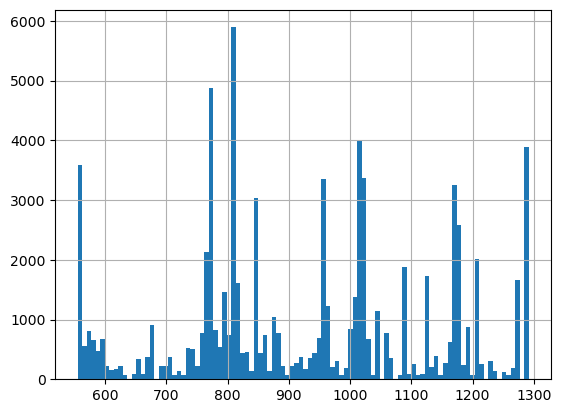

In [76]:
nearest_wind_data[0].hist(bins=100)

In [39]:
# # Function to find nearest wind data coordinates to a point
# def get_wind_power(centroid, tree, unique_coords, wind_data_pivot, hour):
#     print(centroid)
#     distance, index = tree.query([centroid.y, centroid.x])  # Query using y (lat), x (lon)
#     coords = unique_coords[index]

#     if tuple(coords) in wind_data_pivot.index:
#         print(coords)
#         print(wind_data_pivot.loc[tuple(coords), hour])
#         return wind_data_pivot.loc[tuple(coords), hour]
#     else:
#         return np.nan  # or some default value if the coords are not found

In [40]:
# for hour in range(24):
#     environment_gdf[f'wind_power_kW_{hour}'] = environment_gdf['centroid'].apply(
#         lambda centroid: get_wind_power(centroid, tree, unique_coords, wind_data_pivot, hour)
#     )

In [41]:
environment_gdf.to_parquet('../data/processed/environment_gdf.parquet')

In [61]:
environment_gdf.columns

Index(['geometry', 'marine_protected_areas', 'land_nationwide_hapc',
       'areas_protegidas_agencia', 'setbacks_xmission', 'setbacks_roads',
       'setbacks_runway', 'setbacks_airport', 'setbacks_buildings',
       'federal_and_state_waters', 'coastal_zone_mgmt_act_boundary',
       'land_protected_areas', 'water_bodies', 'wrecks_and_obstructions',
       'ocean_disposal_sites', 'tropical_cyclone_storm_segments',
       'tropical_cyclone_wind_exposure', 'danger_zones_and_restricted_areas',
       'unexploded_ordinance_areas', 'PRI_power-density_50m',
       'PRI_power-density_100m', 'PRI_power-density_150m',
       'PRI_power-density_200m', 'PRI_power-density_10m', 'Yearly_PVOUT',
       'Daily_PVOUT', 'slope', 'elevation', 'masked', 'demand', 'centroid',
       'occupied', 'nearest_transmission_dist', 'wind_power_0', 'wind_power_1',
       'wind_power_2', 'wind_power_3', 'wind_power_4', 'wind_power_5',
       'wind_power_6', 'wind_power_7', 'wind_power_8', 'wind_power_9',
       'w

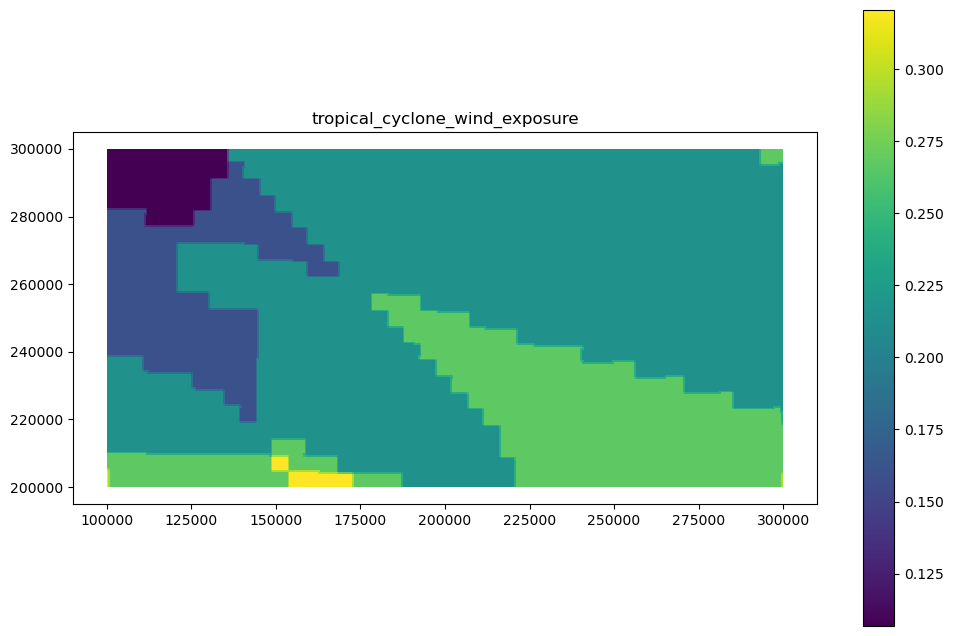

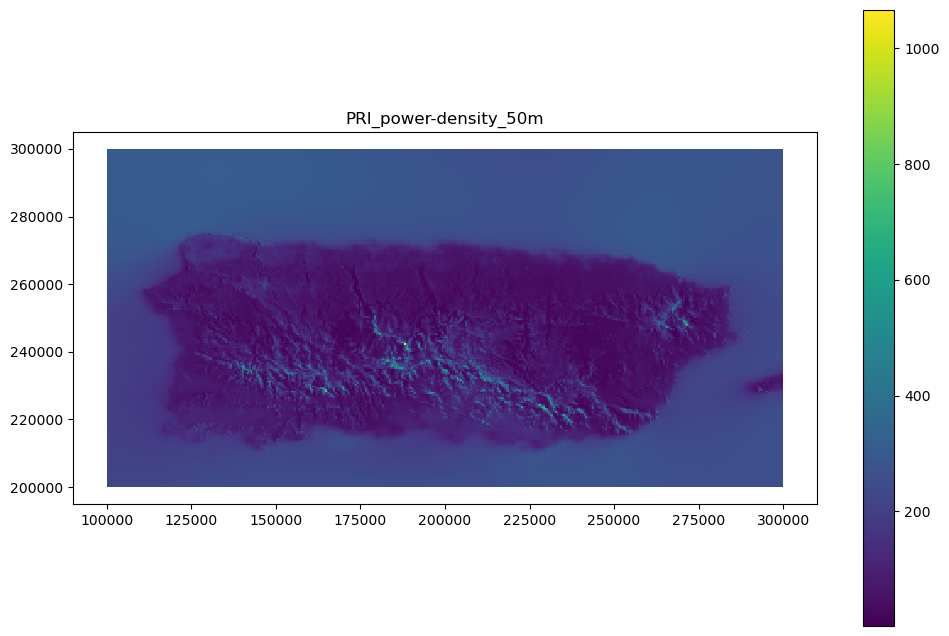

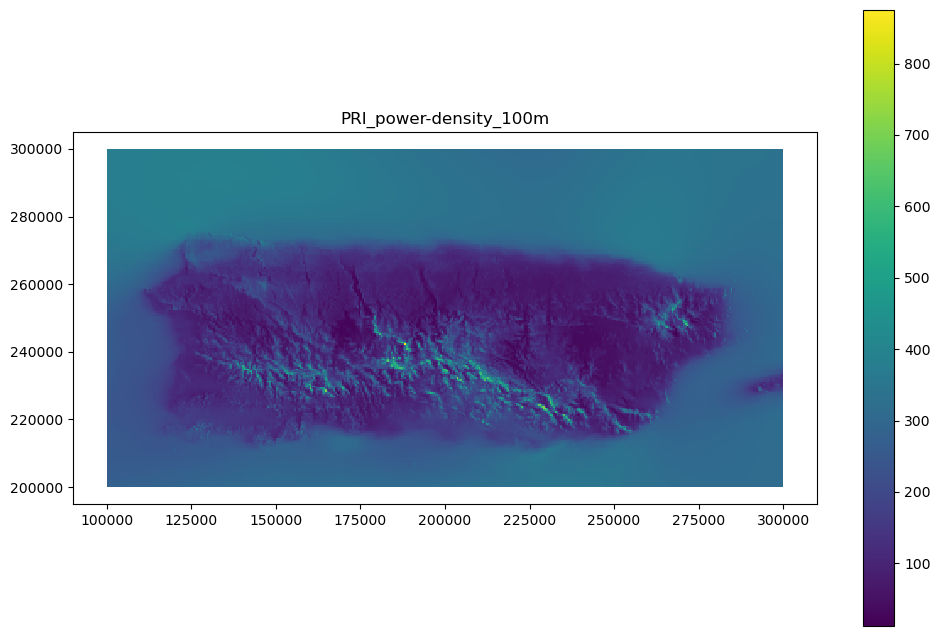

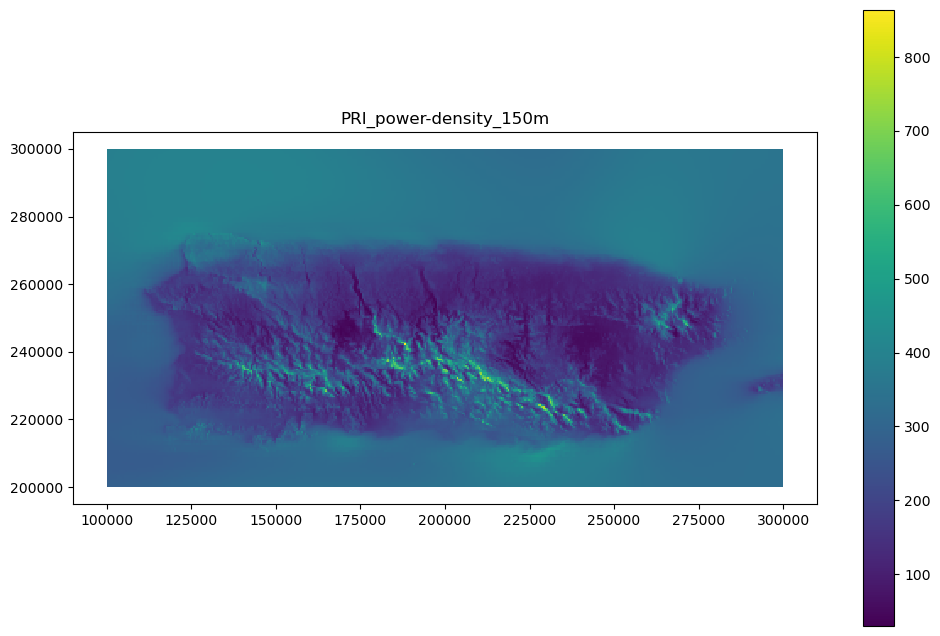

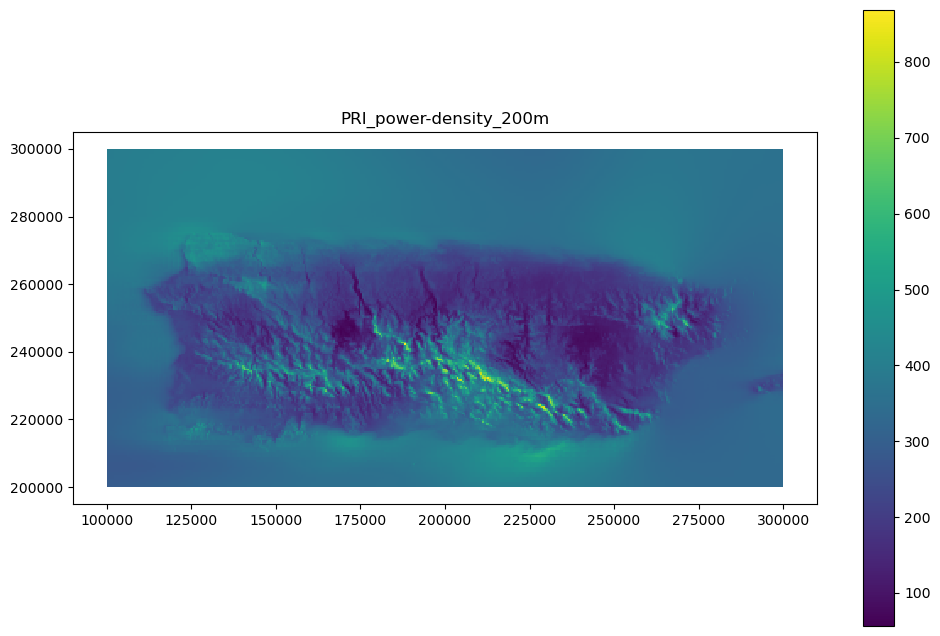

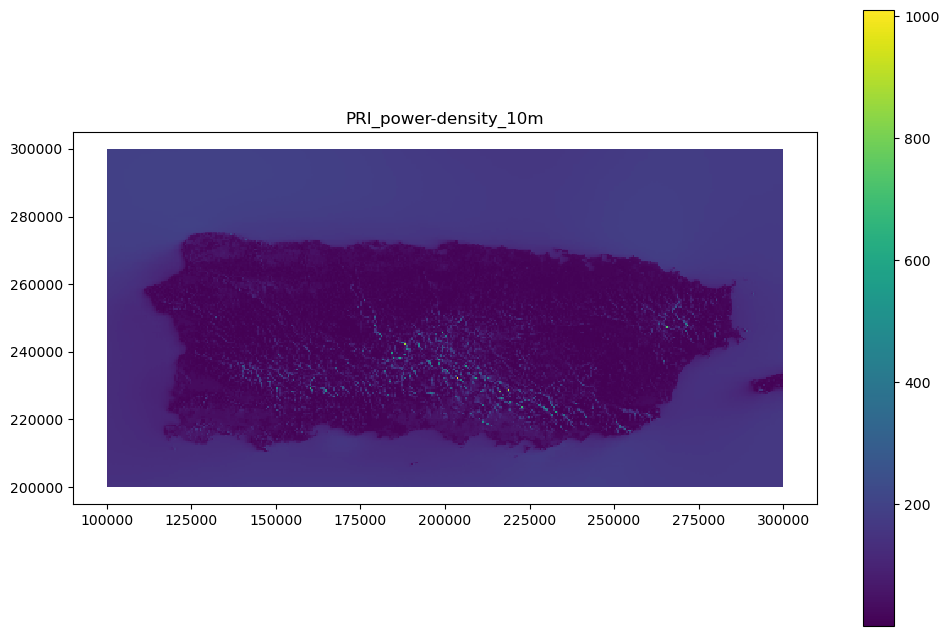

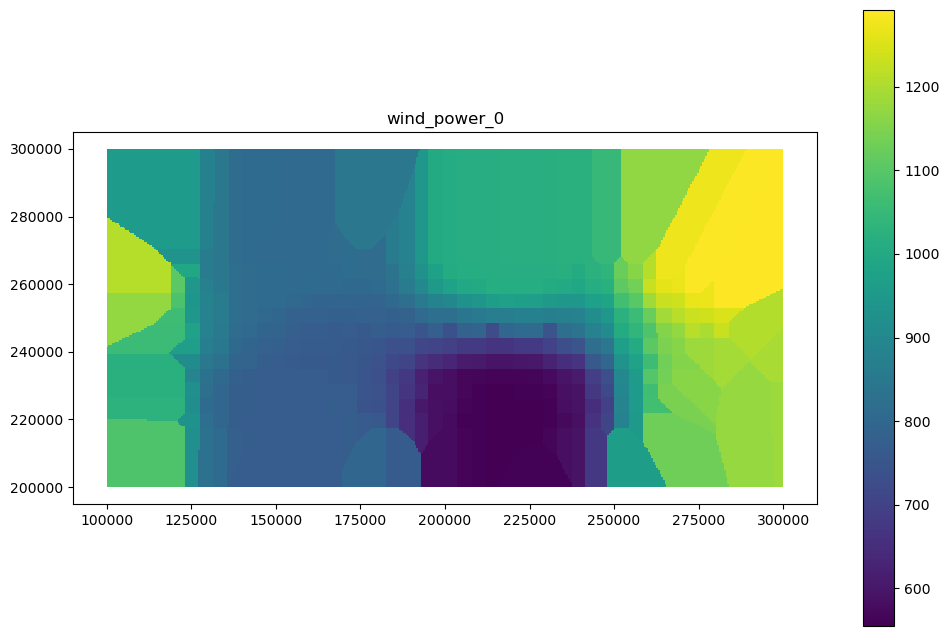

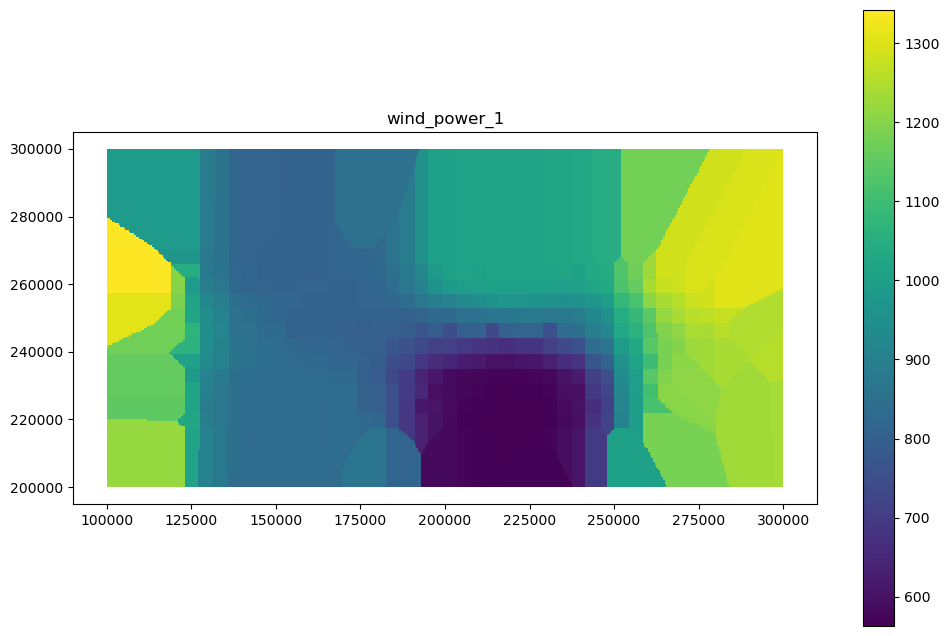

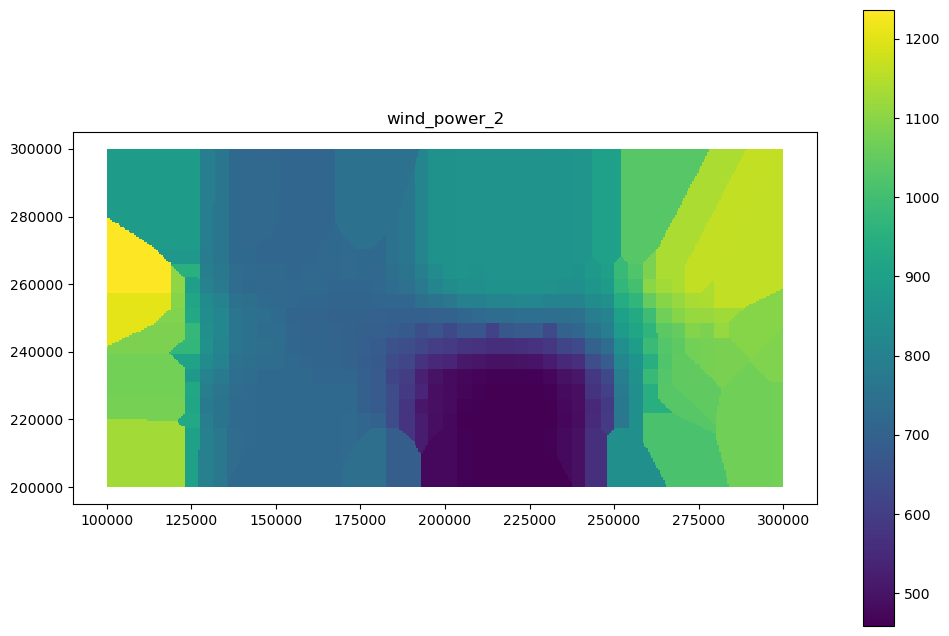

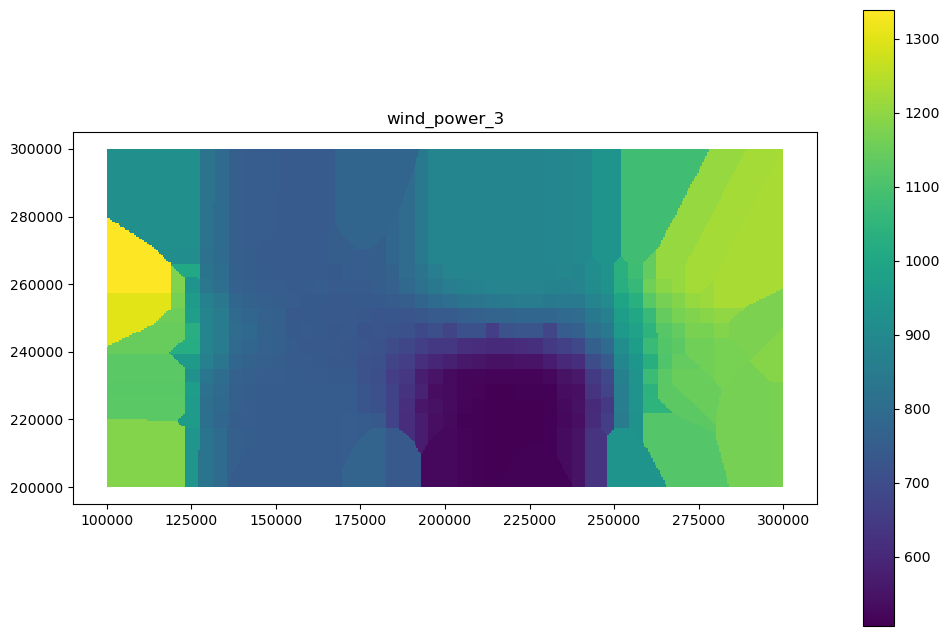

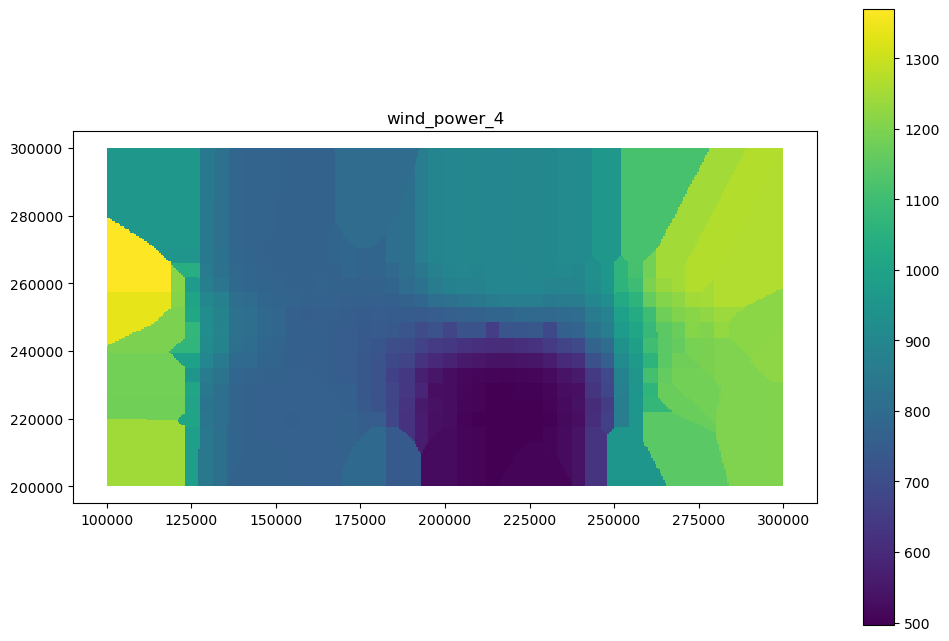

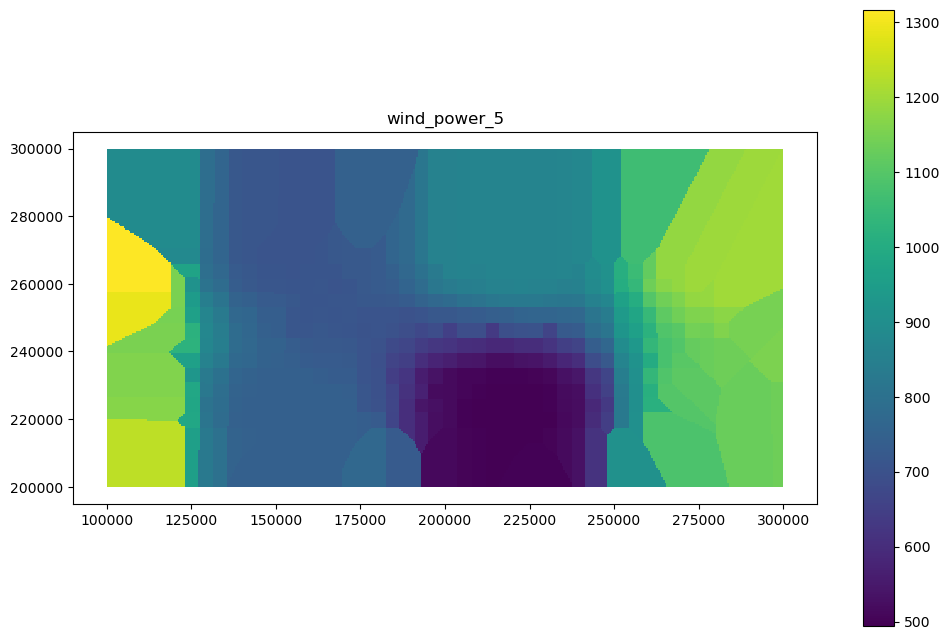

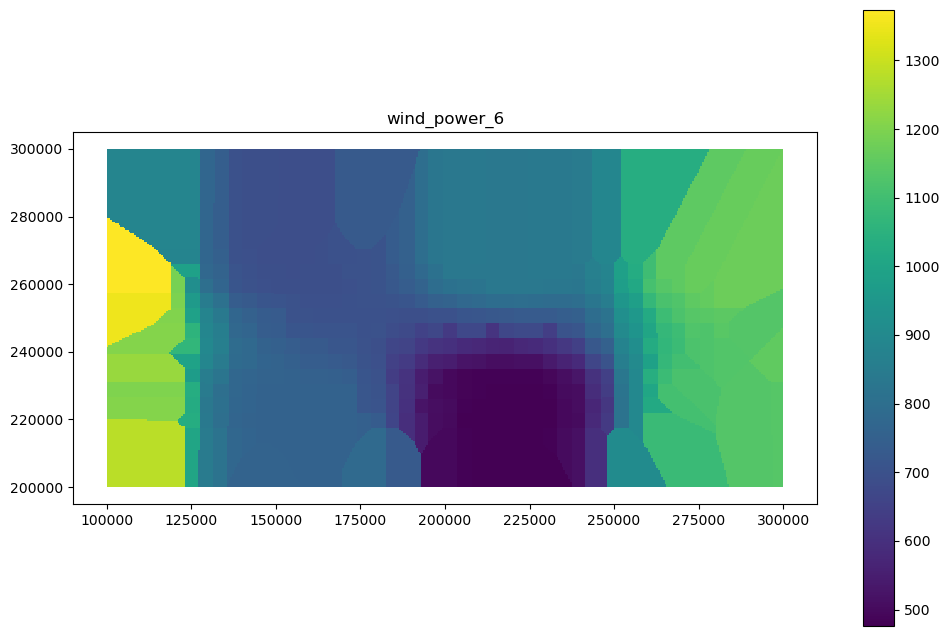

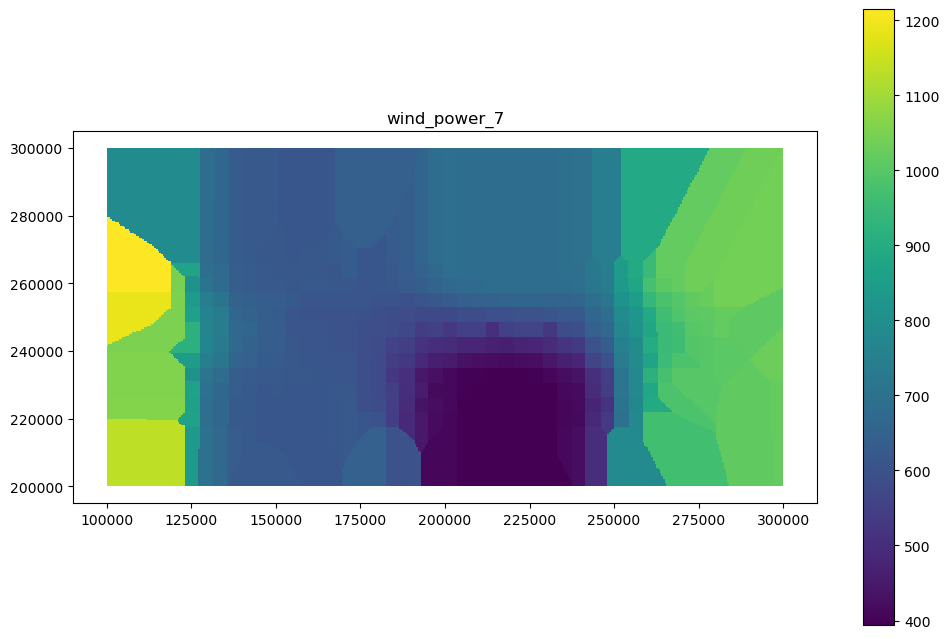

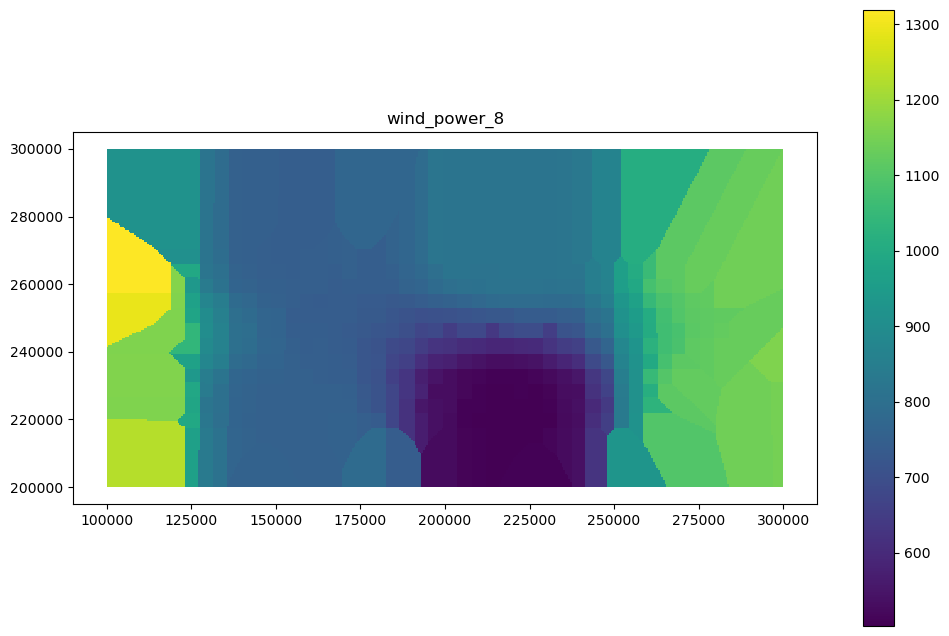

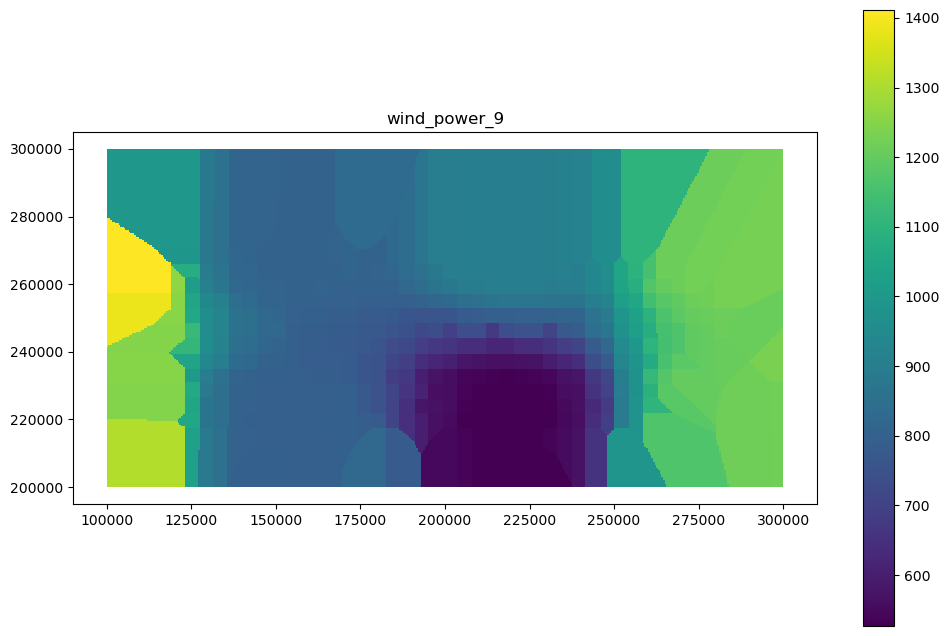

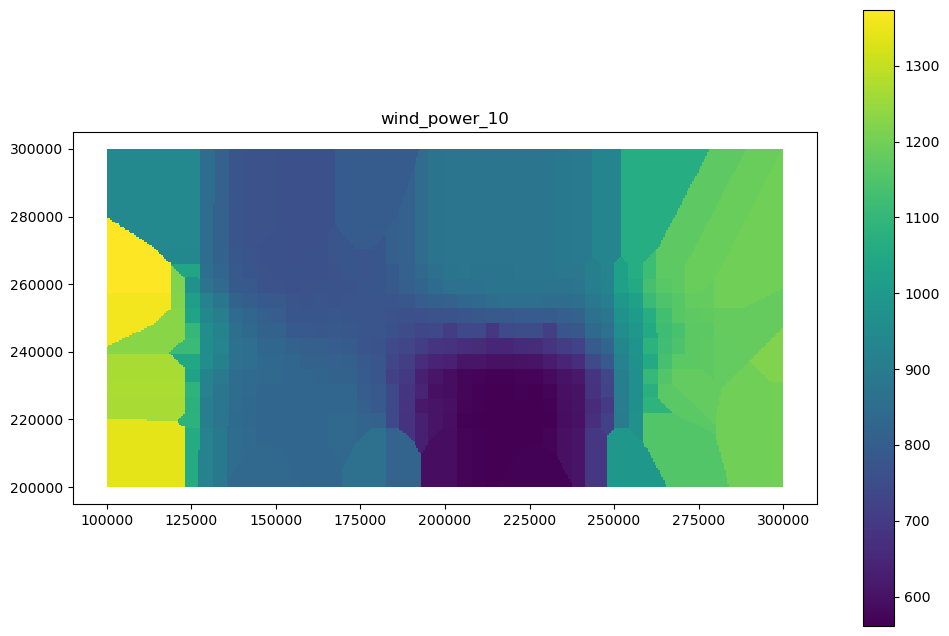

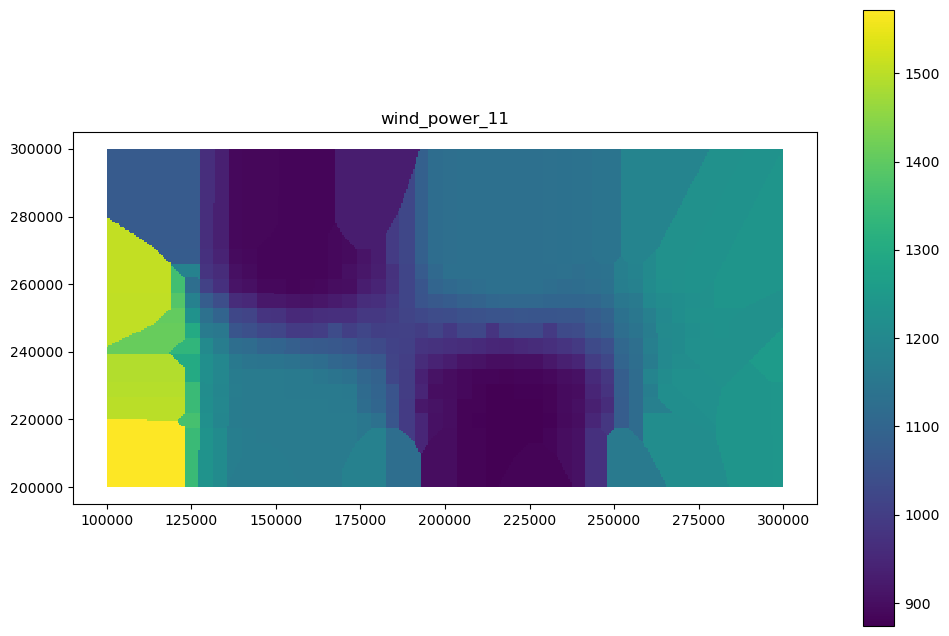

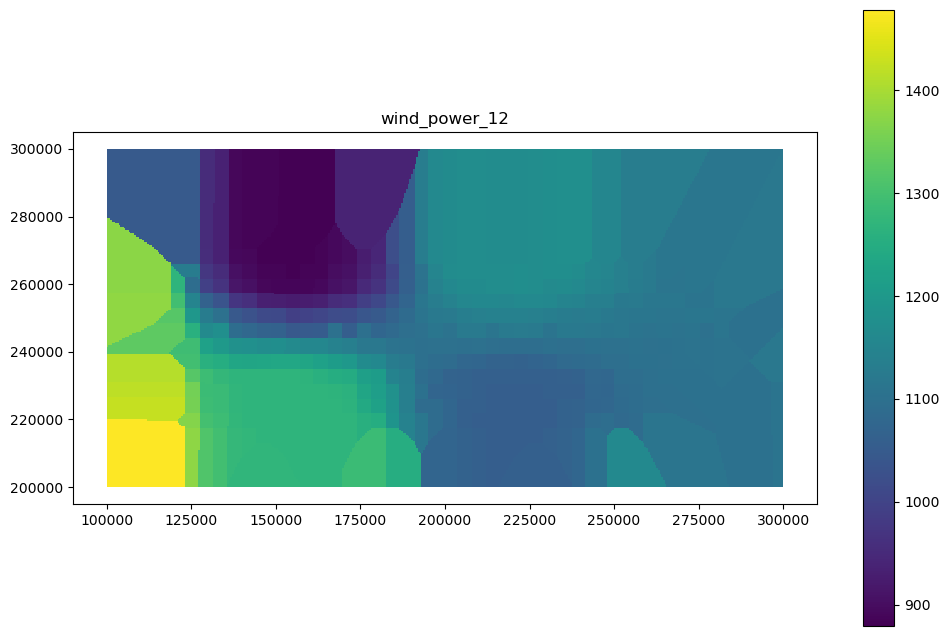

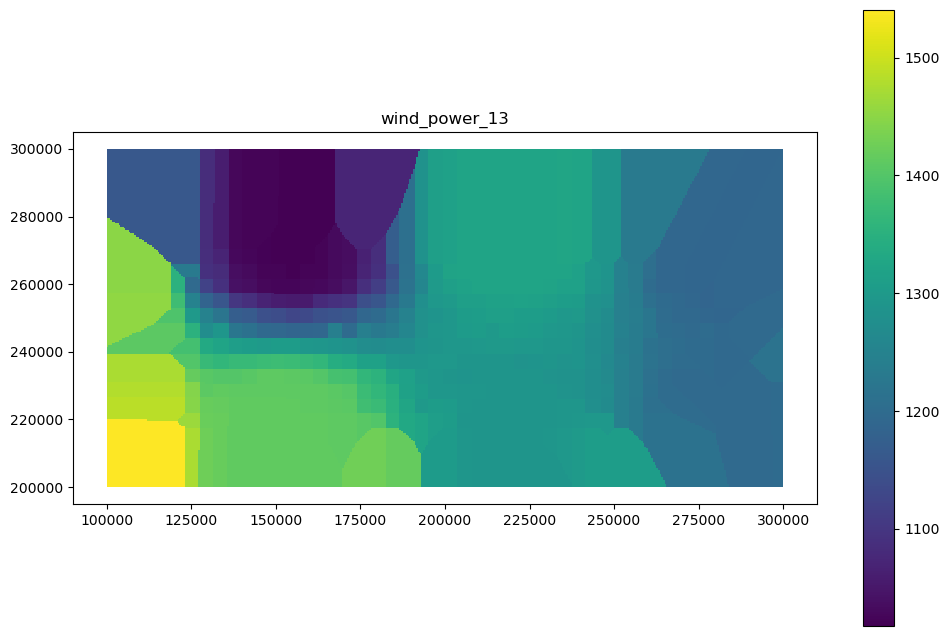

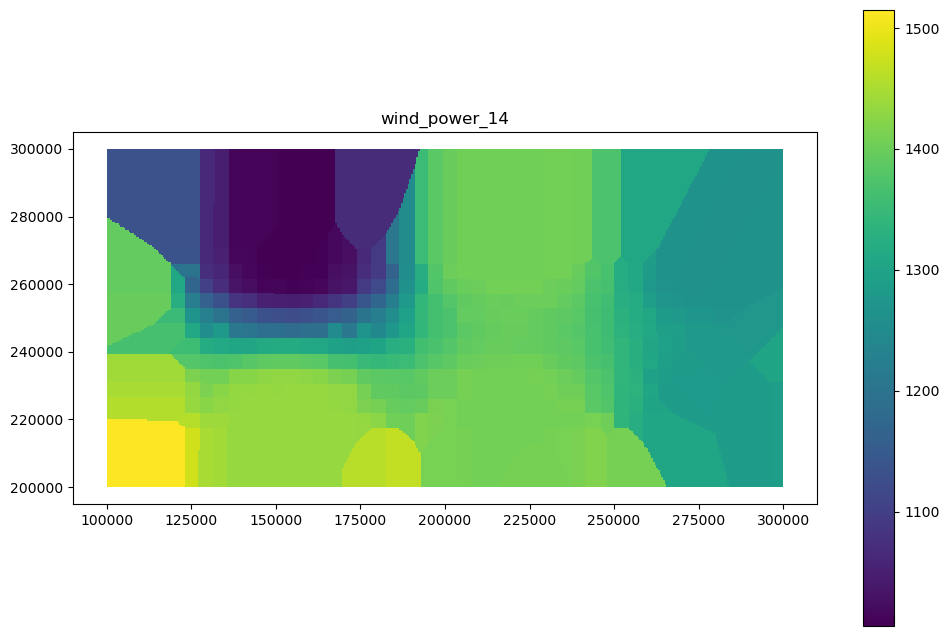

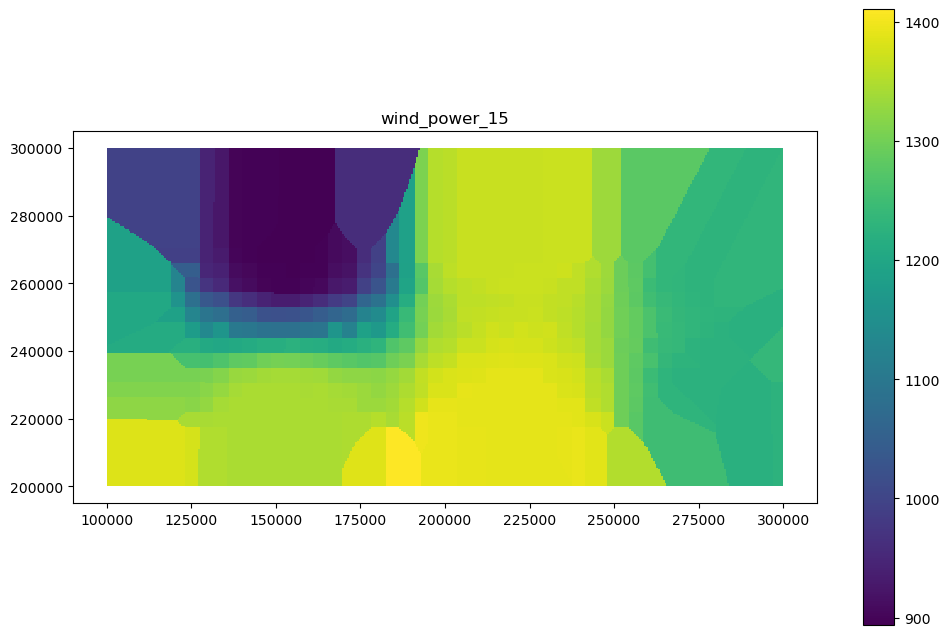

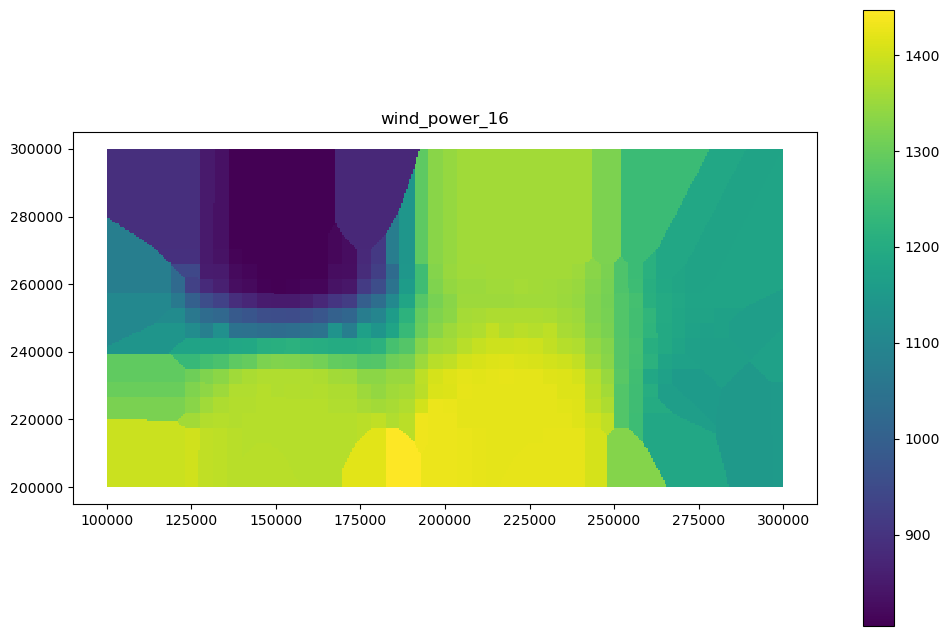

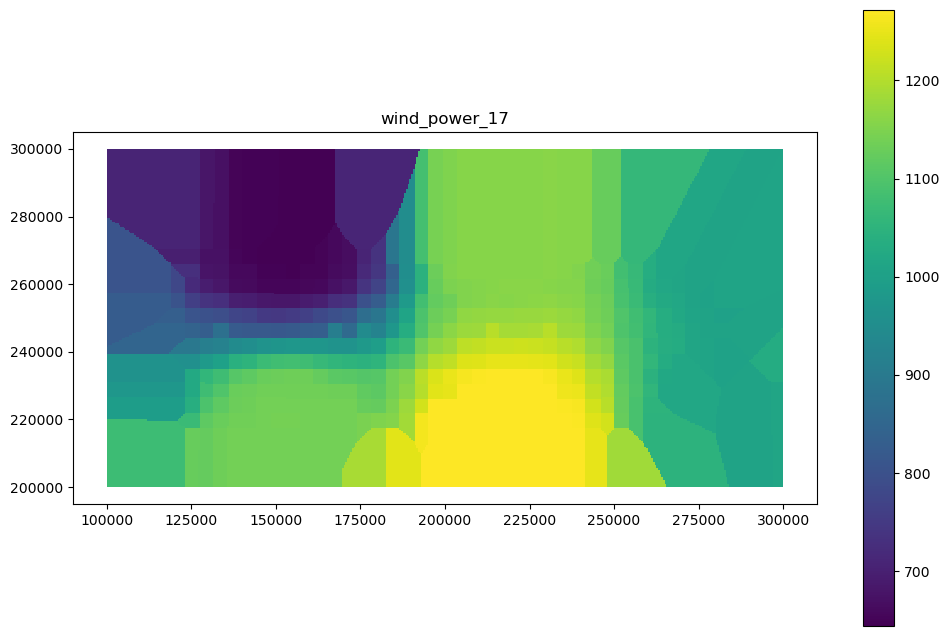

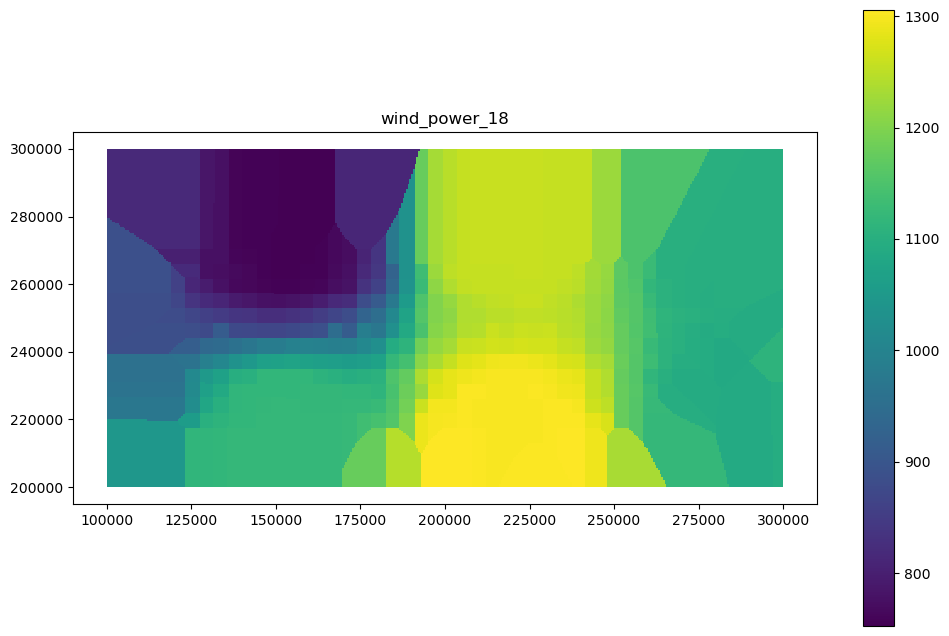

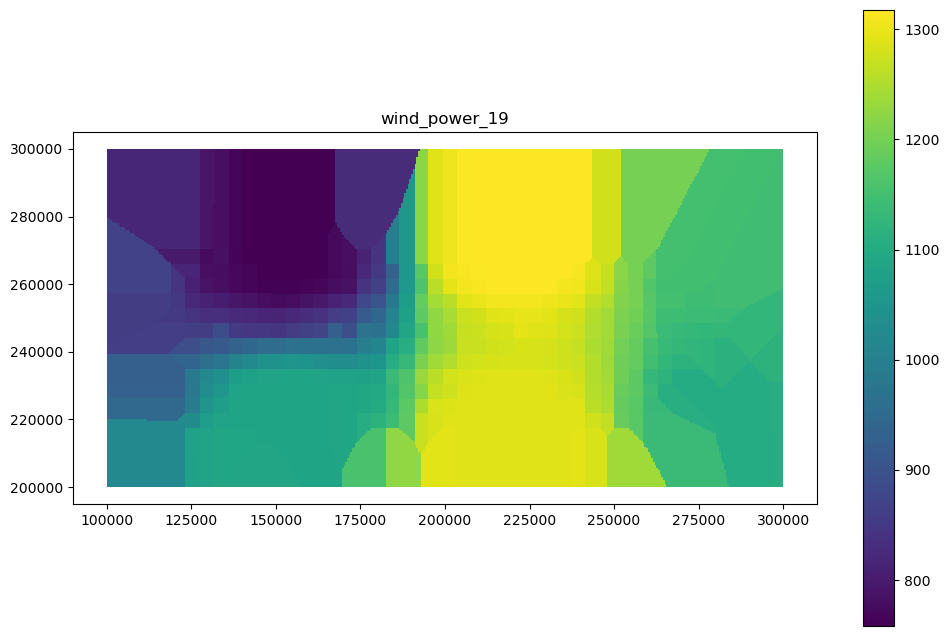

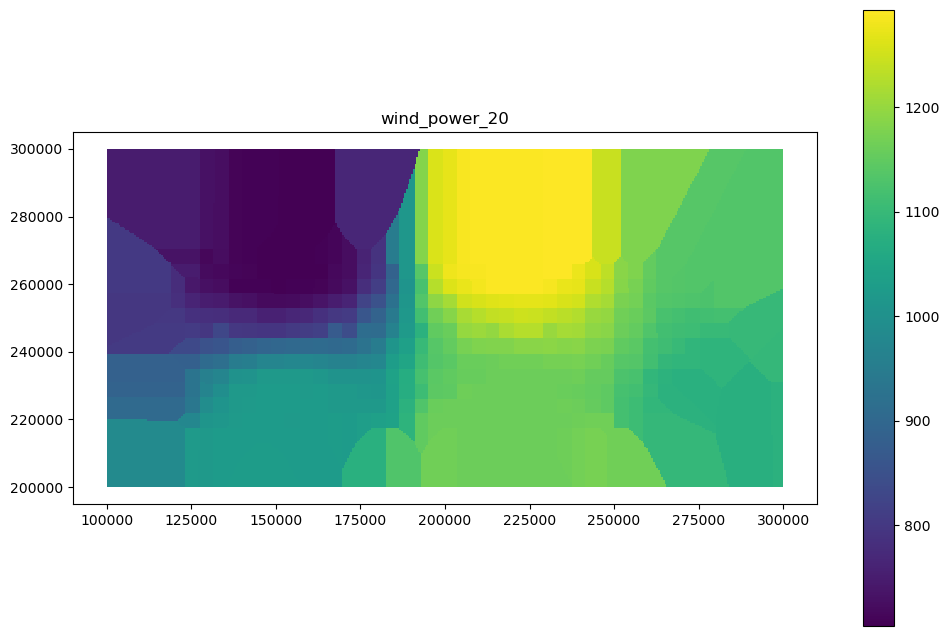

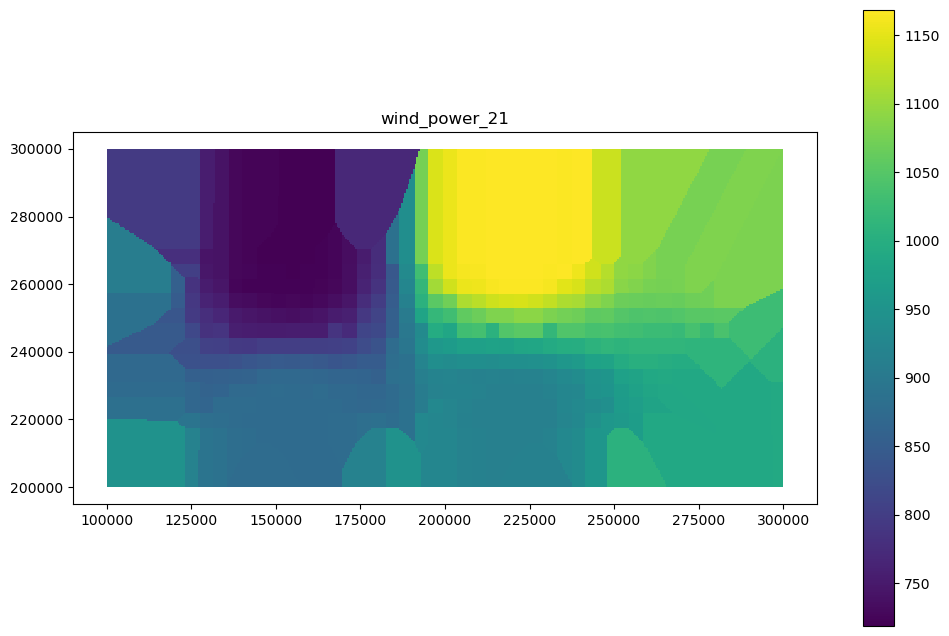

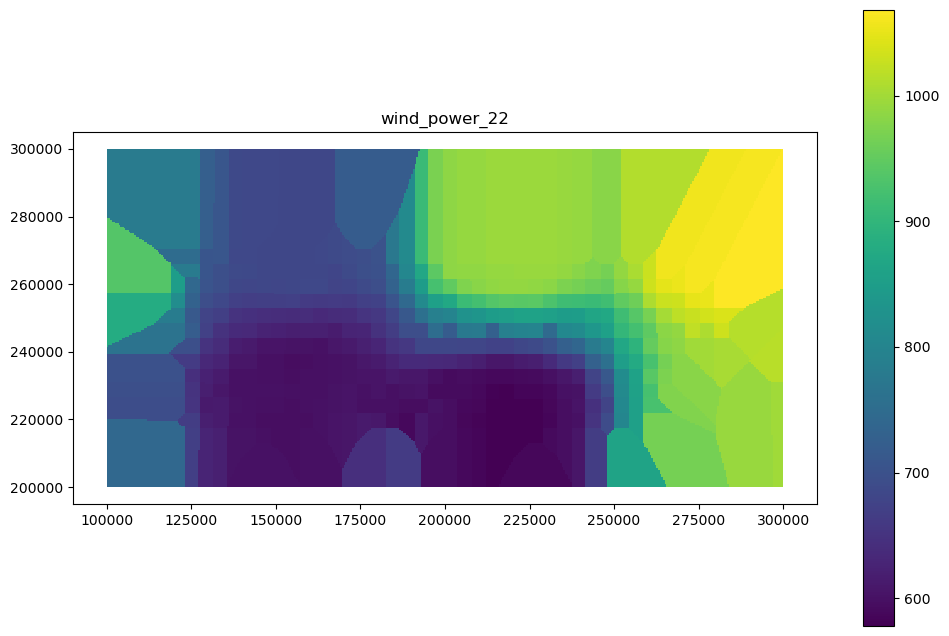

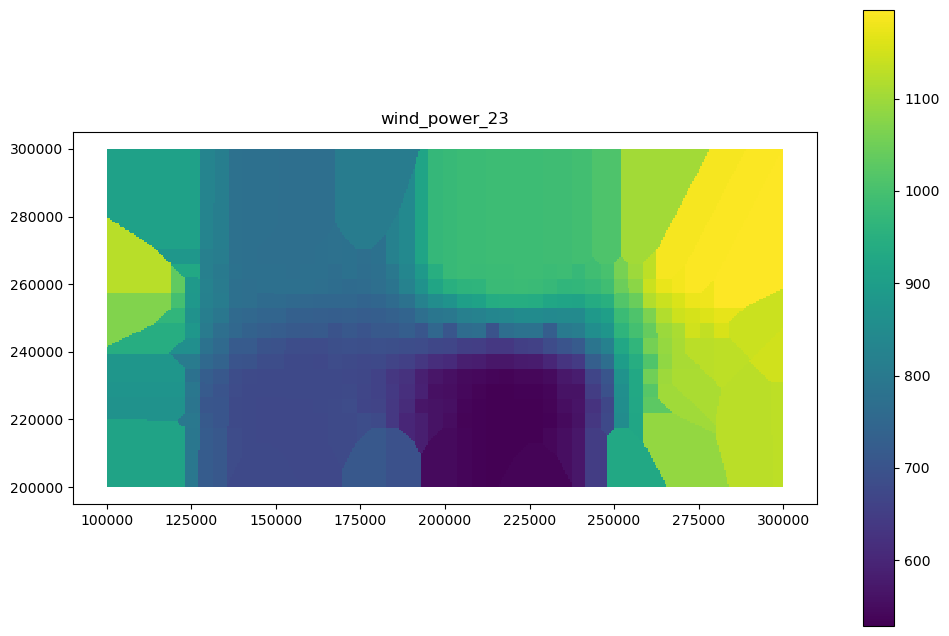

In [79]:
plot_columns(environment_gdf)